<a href="https://colab.research.google.com/github/aida-wofford/Carmen/blob/main/Compare_obs_with_s99_v94.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Specific Objectives.

1) Plot the merged spectrum for all targets.

2) Plot merged spectrum masking the unwanted regions of spectrum.

3) Find by eye the best fitting v94 model with Z=0.020 and Z=0.040, focus on C IV. 

# Resources.

### Definitions.

<b>Young Star Cluster (YSC)</b>. A star cluster of total mass in stars >= 1E4 Msun that contains O and B stars.

<b>Rectified Spectrum</b>. A rectified spectrum is one where the luminosity array 
 has been divided at each wavelength by the value of the continuum at that wavelength.
 For this definition, the continuum is the part of the spectrum that is free of spectral lines.

[Diffraction grating](https://www.khanacademy.org/science/physics/light-waves/interference-of-light-waves/v/diffraction-grating) 

[COS gratings](https://hst-docs.stsci.edu/cosihb/chapter-13-spectroscopic-reference-material/13-3-gratings)

### Python.
[astroquery](https://astroquery.readthedocs.io/en/latest/)

[spectres](https://spectres.readthedocs.io/en/latest/)

### Statistics
[Chi-Sq Test]https://www.statology.org/chi-square-goodness-of-fit-test-python/

### Path to Models and Observations on GitHub.

In [2]:
path='https://raw.githubusercontent.com/aida-wofford/Carmen/main/'

### Names of galaxies and clusters.

In [15]:
galaxies = ['NGC-1512','NGC-1566','M-51']# M-51 = NGC-5194
clusters = ['YSC1','YSC2']

# Activity.

### Instructions.

This activity uses NGC 1512 as an example. Repeat steps for NGC 1566.

### Install and load necessary packages.

In [3]:
!pip install astroquery
!pip install spectres
!pip install pandas
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astroquery.ned import Ned
from spectres import spectres
from matplotlib.pyplot import figure


     |████████████████████████████████| 4.4 MB 13.9 MB/s 
     |████████████████████████████████| 802 kB 58.3 MB/s 
     |████████████████████████████████| 54 kB 1.9 MB/s 
     |████████████████████████████████| 3.0 MB 36.2 MB/s 
  Created wheel for mimeparse: filename=mimeparse-0.1.3-py3-none-any.whl size=3864 sha256=140a2c71d34bef3b3bff27688d0d4f4719f376b152f8313b8e922af447523f90
  Stored in directory: /root/.cache/pip/wheels/49/b4/2d/0081759ae1833bd694024801f7aacddcda8a687e8d5fbaeebd
Successfully built mimeparse


### Define function that uses astroquery to obtain redshift of targets.

In [2]:
def redshift(target):
  result_table = Ned.query_object(target)
  z = result_table['Redshift'][0]
  return z
  
# Example, NGC 1512
print('z=', redshift("NGC 1512"))

z= 0.002995


### Define function to smooth the observed spectra and smoothing factor.

In [18]:
# Define smoothing function
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth
    
sf=5 #smoothing factor

### Create wavelength array to match sampling of model array.

In [6]:
# Model filename.
model = 'v94_z020_10Myr.ifaspec1'

# First age available
t0 = .10000E+05

# Load model
data = np.loadtxt(path + model, skiprows = 6, delimiter = "       ")
t, x, logy, yrec = np.transpose(data)

# Select portion of wavelength array corresponding to t0 and the range between 1150 and 1700 Angstroms.
x99 = x[np.nonzero((t == t0) & (x >= 1150.) & (x <= 1700.))]

### Define function to load and fix observations (correct for redshift, resample and smooth).

In [19]:
def fix_obs(galaxy, cluster, xarray):
  #Load observations and correct for redshift
  z=redshift(galaxy)
  x130_rectified = np.genfromtxt(path+galaxy+'-'+cluster+'_G130M_normspec_wLya.dat', usecols=0) / (1 + z)
  y130_rectified = np.genfromtxt(path+galaxy+'-'+cluster+'_G130M_normspec_wLya.dat', usecols=4)
  x160_rectified = np.genfromtxt(path+galaxy+'-'+cluster+'_G160M_normspec_wLya.dat', usecols=0) / (1 + z)
  y160_rectified = np.genfromtxt(path+galaxy+'-'+cluster+'_G160M_normspec_wLya.dat', usecols=4)
  #Resample observations
  y130_resampled = spectres(xarray, x130_rectified, y130_rectified, fill=0.)
  y160_resampled = spectres(xarray, x160_rectified, y160_rectified, fill=0.)
  #Smooth observations
  y130_smoothed = smooth(y130_resampled, sf)
  y160_smoothed = smooth(y160_resampled, sf)
  return y130_resampled, y160_resampled, y130_smoothed, y160_smoothed



### Define function to average in the overlapping region.


In [23]:
def merge(galaxy, cluster):
# Set necesart variables
  y130resampled = fix_obs(galaxy, cluster, x99)[0]
  y160resampled = fix_obs(galaxy, cluster, x99)[1]
  y130smoothed = fix_obs(galaxy, cluster, x99)[2]
  y160smoothed = fix_obs(galaxy, cluster, x99)[3]

# Mininum G160M wavelength with non-zero flux. 
  y160min=min(x99[np.nonzero((x99 < 1450.) & (y160resampled > 0.))])

# Number of G160M wavelength points with non-zero fluxes
  n160=len(x99[np.nonzero(x99 >= y160min)])

# Maximum G130M wavelength with non-zero flux.
  y130max=max(x99[np.nonzero((x99 < 1450.) & (y130resampled > 0.))])

# Number of G130M wavelength points with non-zero fluxes (except for segment gap)
  n130=len(x99[np.nonzero(x99 <= y130max)])

# Number of wavelength points in overlapping region between G130M and G160M.
  noverlap=len(x99[np.nonzero((x99 >= y160min) & (x99 <= y130max))])


# Index of G160M array where non-zero fluxes start.
  y_index_160_overlap_lo = np.where(x99 == y160min)

# Index of G160M array where overlap region ends.
  y_index_160_overlap_hi = np.where(x99 == y130max)

# Let y be the G130M + G160M spectrum of YSC1. The flux of the overlapping region 
# will be the average between the G130M and G160M fluxes. 
  y=[]

# We fill in the blue part of the merged array.
  for i in range(n130 - noverlap):
      y.append(y130resampled[i])


# We fill overlapping region of the merged array.
  for i in range(noverlap):
      y.append( (y130resampled[n130 - noverlap + i] + 
                y160resampled[y_index_160_overlap_lo[0] + i][0] ) / 2 )
        
# We fill the red part of the merged array.
  for i in range(n160 - noverlap):
      y.append( y160resampled[y_index_160_overlap_hi[0] + i])

# Smooth
  y_smooth = smooth(y,sf)
  return y_smooth

### Set up for plotting.

In [21]:
# Set plot fontsize
size=14
wg='regular'
font = {'family' : 'serif',
        'weight' : wg,
        'size'   : size}
plt.rc('font', **font)

# Plot in this notebook
%matplotlib inline





Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outs

/usr/local/lib/python3.7/dist-packages/numpy/core/numeric.py:809: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  a, v = array(a, copy=False, ndmin=1), array(v, copy=False, ndmin=1)



Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outs

/usr/local/lib/python3.7/dist-packages/numpy/core/numeric.py:809: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  a, v = array(a, copy=False, ndmin=1), array(v, copy=False, ndmin=1)



Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outs

/usr/local/lib/python3.7/dist-packages/numpy/core/numeric.py:809: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  a, v = array(a, copy=False, ndmin=1), array(v, copy=False, ndmin=1)



Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outs

/usr/local/lib/python3.7/dist-packages/numpy/core/numeric.py:809: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  a, v = array(a, copy=False, ndmin=1), array(v, copy=False, ndmin=1)



Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outs

/usr/local/lib/python3.7/dist-packages/numpy/core/numeric.py:809: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  a, v = array(a, copy=False, ndmin=1), array(v, copy=False, ndmin=1)



Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outs

/usr/local/lib/python3.7/dist-packages/numpy/core/numeric.py:809: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  a, v = array(a, copy=False, ndmin=1), array(v, copy=False, ndmin=1)


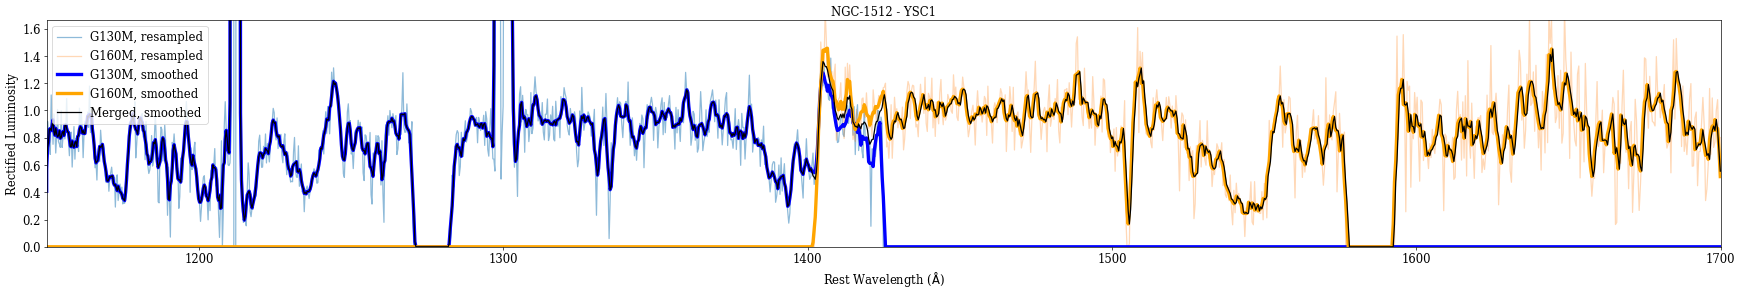

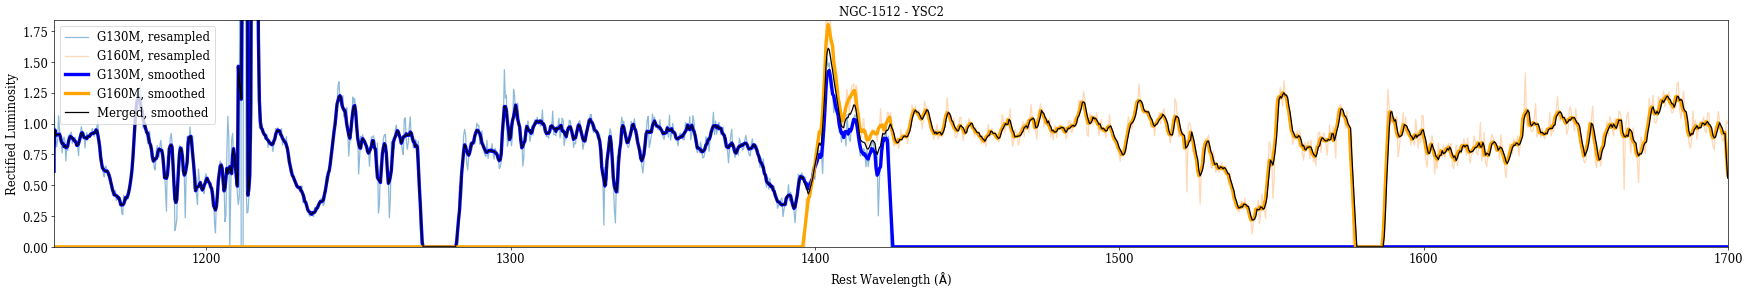

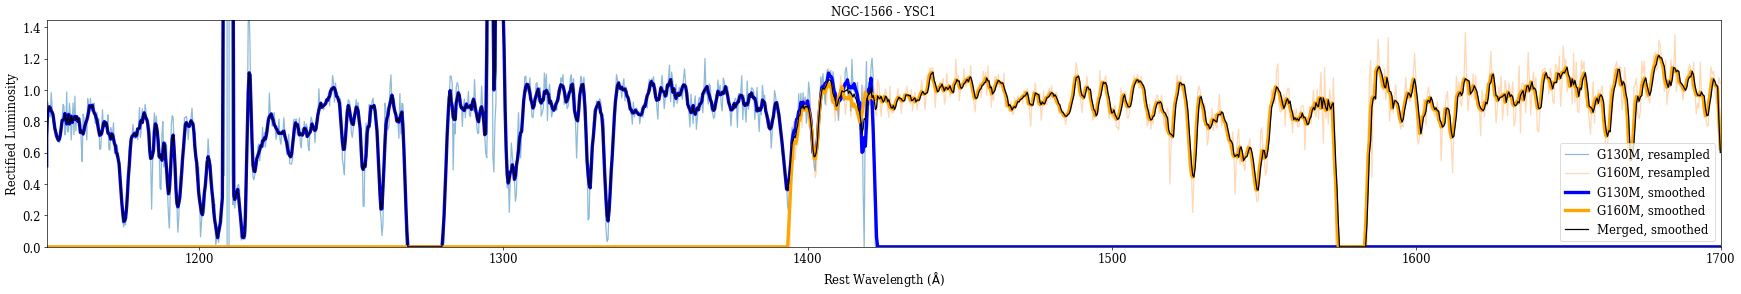

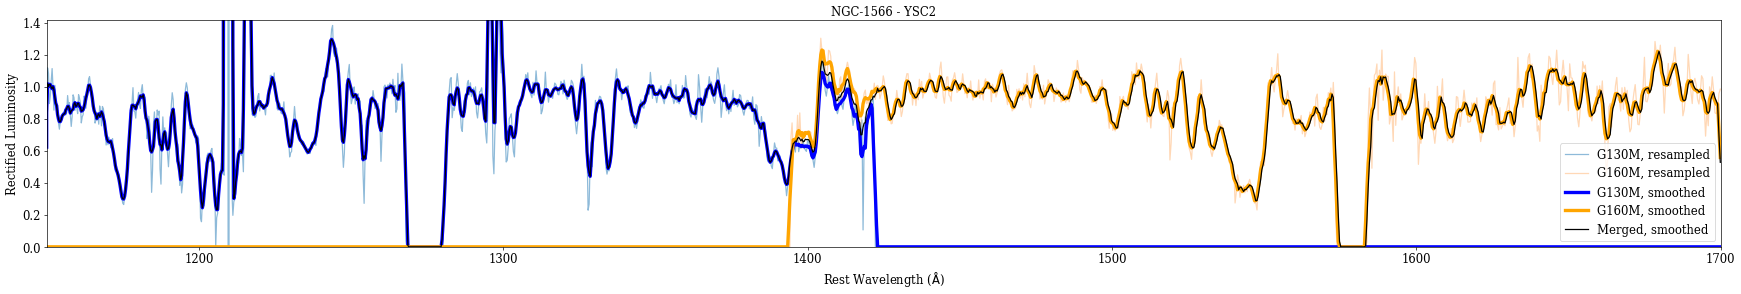

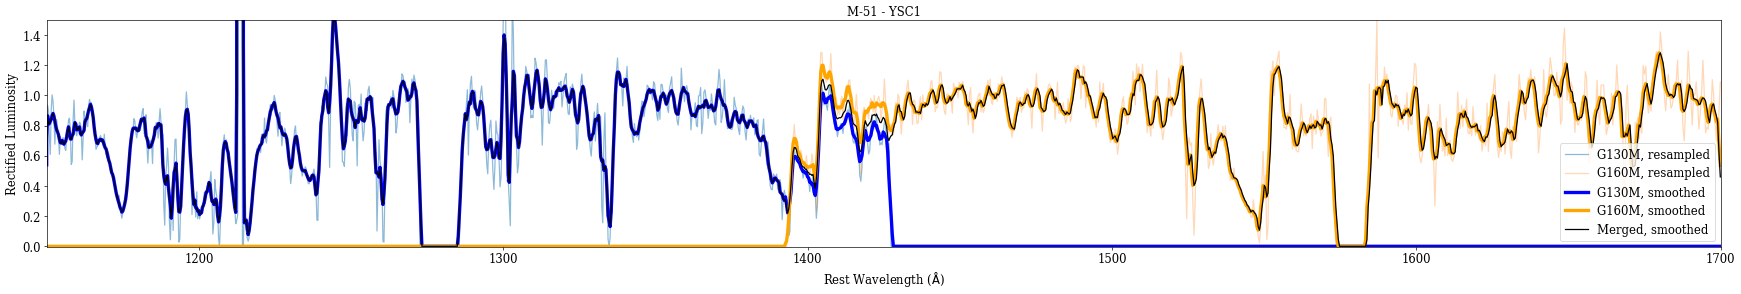

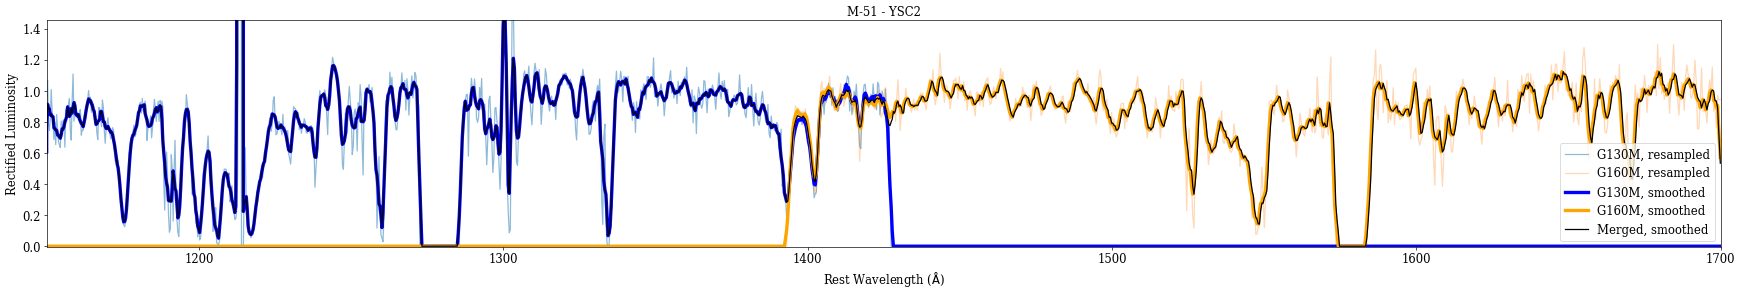

In [30]:
for igalaxy in range(3):
  galaxy = galaxies[igalaxy]
  for icluster in range(2):
    cluster = clusters[icluster]

# Load variables to be plotted
    y130resampled = fix_obs(galaxies[igalaxy], clusters[icluster], x99)[0]
    y160resampled = fix_obs(galaxies[igalaxy], clusters[icluster], x99)[1]
    y130smoothed = fix_obs(galaxies[igalaxy], clusters[icluster], x99)[2]
    y160smoothed = fix_obs(galaxies[igalaxy], clusters[icluster], x99)[3]
    ysmoothed = merge(galaxies[igalaxy], clusters[icluster])
# Plot result for YSC1
    fig, axes = plt.subplots(figsize=(36,5), dpi=60)

# Set plot title
    plt.title(galaxy + ' - ' + cluster, fontsize = size)

# Set limits of horizontal axis
    plt.xlim(1150.,1700.)

# Set label of horizontal axis
    plt.xlabel(r'Rest Wavelength ($\rm{\AA}$)', fontsize=size)

# Set limits of vertical axis
    good_x = np.where(x99 >= 1320) 
    plt.ylim(min(y130resampled[good_x]), 1.2*max(y130resampled[good_x]))

# Set label of vertical axis
    plt.ylabel('Rectified Luminosity', fontsize=size)

# Change font of tick axis labels
    for tick in axes.xaxis.get_major_ticks():
                tick.label.set_fontsize(14)
    for tick in axes.yaxis.get_major_ticks():
                tick.label.set_fontsize(14)

# Plot resampled, unsmoothed data
    plt.plot(x99, y130resampled, alpha=0.5, label='G130M, resampled')
    plt.plot(x99, y160resampled, alpha=0.3, label='G160M, resampled')

# Overlay resampled, smoothed data
    plt.plot(x99, y130smoothed, color='blue', alpha=1, 
             label='G130M, smoothed', linewidth=4)
    plt.plot(x99, y160smoothed, color='orange', alpha=1, 
             label='G160M, smoothed', linewidth=4)

# Overlay merged, smoothed data
    plt.plot(x99, ysmoothed, color='black', alpha=1, label='Merged, smoothed',
             linestyle='-')

# Mark positions of lines of interest
    #plt.axvline(x=1334.53,color='black',alpha=1,zorder=0, linestyle='--')
    #plt.axvline(x=1393.76,color='black',alpha=1,zorder=0, linestyle='--')
    #plt.axvline(x=1402.77,color='black',alpha=1,zorder=0, linestyle='--')

# Add legend
    plt.legend(fontsize=size)


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outs

/usr/local/lib/python3.7/dist-packages/numpy/core/numeric.py:809: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  a, v = array(a, copy=False, ndmin=1), array(v, copy=False, ndmin=1)



Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outs

/usr/local/lib/python3.7/dist-packages/numpy/core/numeric.py:809: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  a, v = array(a, copy=False, ndmin=1), array(v, copy=False, ndmin=1)



Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outs

/usr/local/lib/python3.7/dist-packages/numpy/core/numeric.py:809: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  a, v = array(a, copy=False, ndmin=1), array(v, copy=False, ndmin=1)



Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outs

/usr/local/lib/python3.7/dist-packages/numpy/core/numeric.py:809: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  a, v = array(a, copy=False, ndmin=1), array(v, copy=False, ndmin=1)



Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outs

/usr/local/lib/python3.7/dist-packages/numpy/core/numeric.py:809: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  a, v = array(a, copy=False, ndmin=1), array(v, copy=False, ndmin=1)



Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 


Spectres: new_wavs contains values outs

/usr/local/lib/python3.7/dist-packages/numpy/core/numeric.py:809: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  a, v = array(a, copy=False, ndmin=1), array(v, copy=False, ndmin=1)


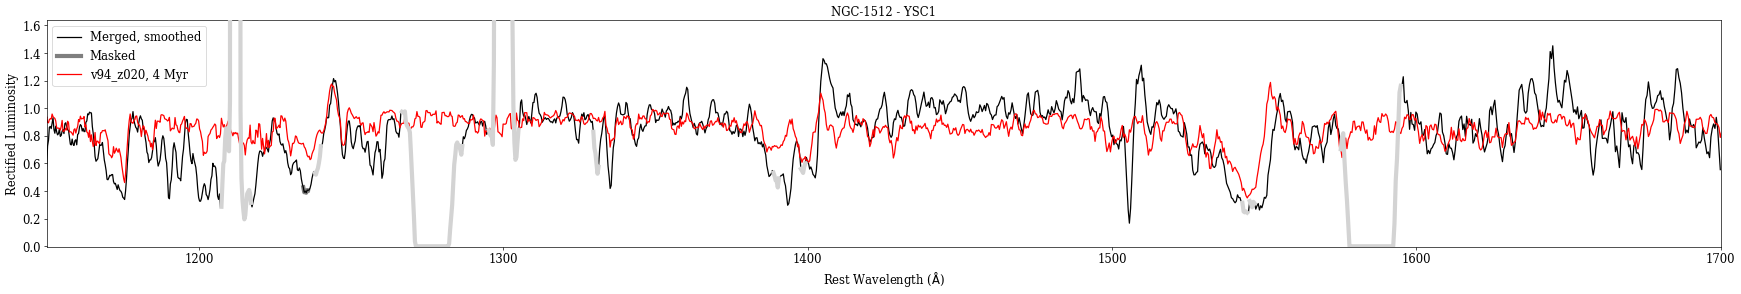

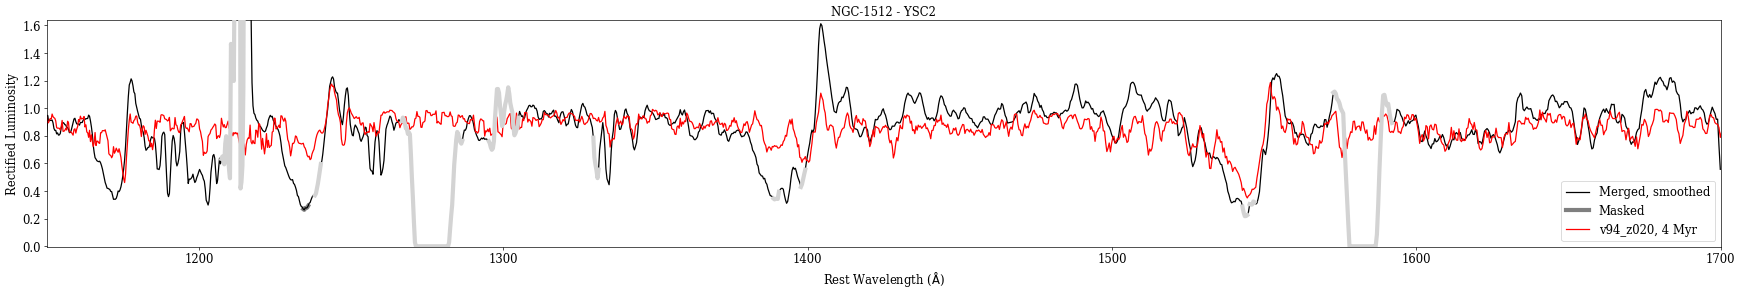

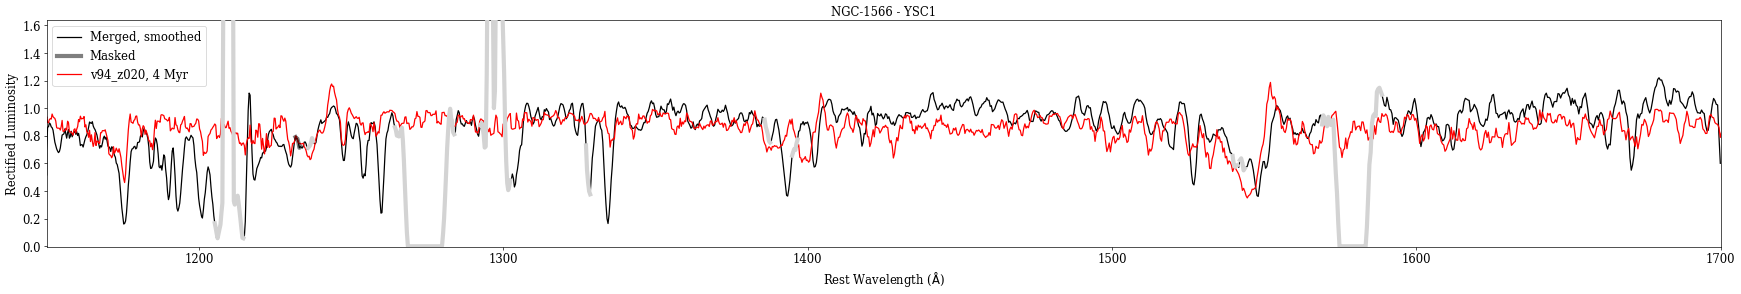

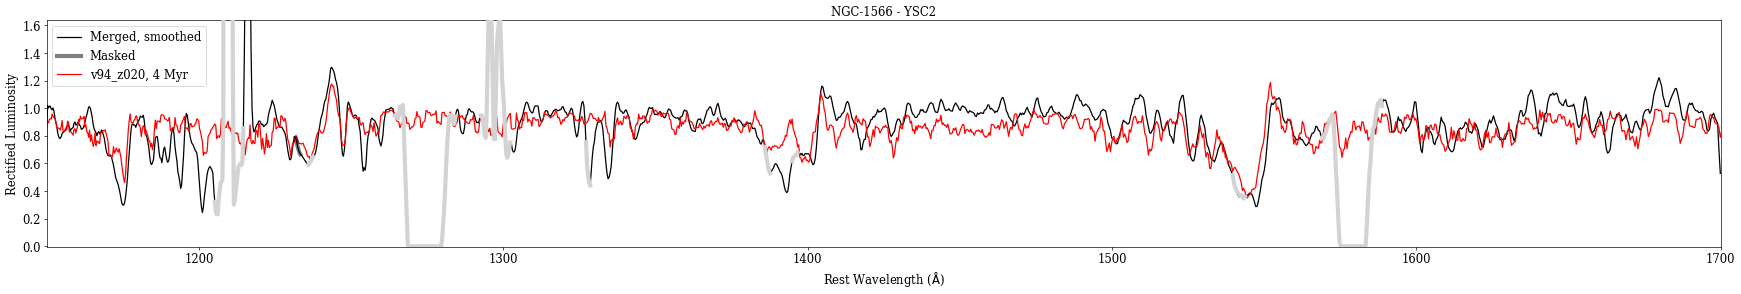

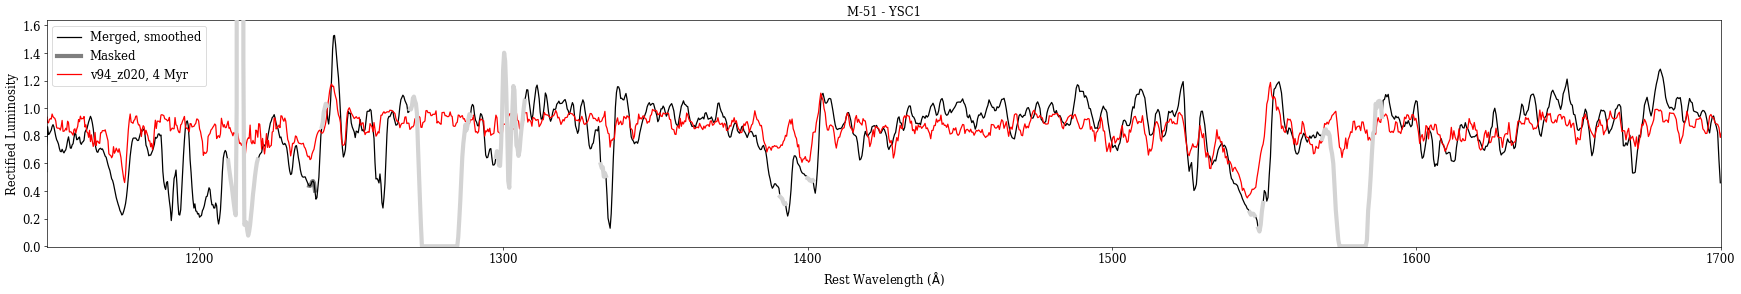

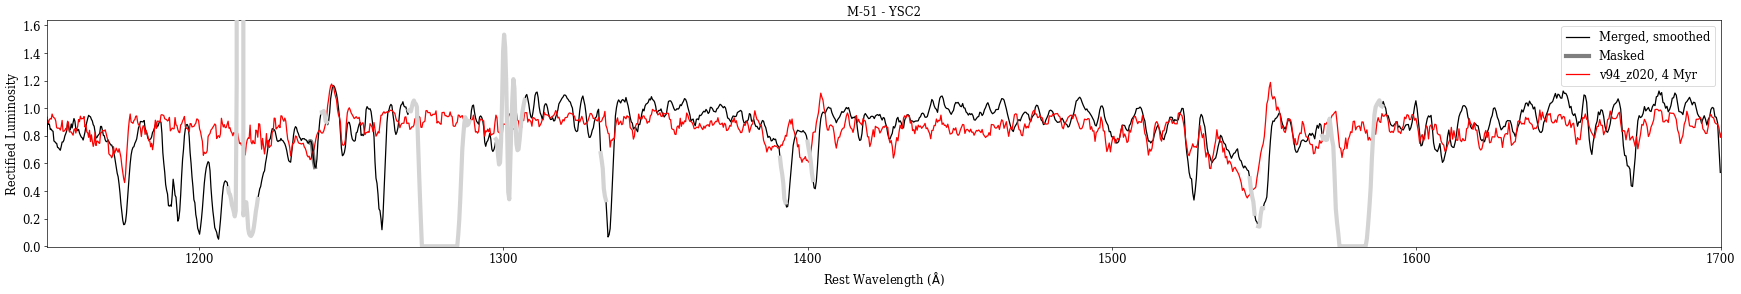

In [57]:
# Line list for masks
#Milky Way
mw=[1238.82, 1242.80,# N V
    1334.53,
    1393.76, 1402.77,# Si IV
    1548.19, 1550.77,# C IV
    ]
#geocoronal
geo=[1216., 
     1304.]

xlo=1500
xhi=1580

# Models
model=['v94_z020', 'v94_z040']

# Initial time step of models in Myr
t0 = .1e5 

# Ages of interest
ages = [1e6, 2e6, 3e6, 4e6, 5e6, 6e6, 7e6, 8e6, 9e6, 10e6]# in Myr
#        0     1   2     3   4

iage=3
imodel=0

# Load data of models to be compared into variables
data=np.loadtxt(path + model[imodel] + '_10Myr.ifaspec1', skiprows=6, delimiter="       ")
time, wave, logL, norm = np.transpose(data)
good_indices = np.where(time == ages[iage] + t0)
x=wave[good_indices]
y=norm[good_indices]

for igalaxy in range(3):
  galaxy = galaxies[igalaxy]
  z=redshift(galaxy)
  for icluster in range(2):
    cluster = clusters[icluster]

# Load variables to be plotted
    ysmoothed = merge(galaxies[igalaxy], clusters[icluster])
# Plot result for YSC1
    fig, axes = plt.subplots(figsize=(36,5), dpi=60)

# Set plot title
    plt.title(galaxy + ' - ' + cluster, fontsize = size)

# Set limits of horizontal axis
    plt.xlim(1150.,1700.)

# Set label of horizontal axis
    plt.xlabel(r'Rest Wavelength ($\rm{\AA}$)', fontsize=size)

# Set limits of vertical axis
    good_x = np.where(x99 >= 1320) 
    plt.ylim(min(y130resampled[good_x]), 1.35*max(y130resampled[good_x]))

# Set label of vertical axis
    plt.ylabel('Rectified Luminosity', fontsize=size)

# Change font of tick axis labels
    for tick in axes.xaxis.get_major_ticks():
                tick.label.set_fontsize(14)
    for tick in axes.yaxis.get_major_ticks():
                tick.label.set_fontsize(14)

# Overlay merged, smoothed data
    plt.plot(x99, ysmoothed, color='black', alpha=1, label='Merged, smoothed',
             linestyle='-')

# Mask positions of contaminating MW lines
    for i in range(len(mw)):
      bad=np.nonzero(abs(x99 - mw[i]/(1+z)) <= 1.)
      if i==0:
        plt.plot(x99[bad], ysmoothed[bad], color='black', linewidth='5', alpha=0.5, 
         zorder=10, label='Masked')
      else:
        plt.plot(x99[bad], ysmoothed[bad], color='lightgrey', linewidth='5', alpha=1, 
         zorder=10)    

    for i in range(len(geo)):
      bad=np.nonzero(abs(x99 - geo[i]/(1+z)) <= 5.)
      plt.plot(x99[bad], ysmoothed[bad], color='lightgrey', linewidth='5', alpha=1, 
         zorder=10)

#Segment gap 1
    ybad=np.nonzero((x99 < 1300) & (ysmoothed==0.))
    yave_gap1=(max(x99[ybad])+min(x99[ybad]))/2
    ybad=np.nonzero(abs(x99 - yave_gap1) <= 10.)
    plt.plot(x99[ybad], ysmoothed[ybad], color='lightgrey', linewidth='5', alpha=1, 
         zorder=10)

#Segment gap 2
    ybad=np.nonzero((x99 > 1500) & (ysmoothed==0.))
    yave_gap2=(max(x99[ybad])+min(x99[ybad]))/2
    ybad=np.nonzero(abs(x99 - yave_gap2) <= 10.)
    plt.plot(x99[ybad], ysmoothed[ybad], color='lightgrey', linewidth='5', alpha=1, 
         zorder=10)

# Overlay model
    plt.plot(x, smooth(y,5), color='red', label=model[imodel]+', '+str(iage+1)+' Myr')
# Add legend
    plt.legend(fontsize=size)

#plt.savefig(galaxies[igalaxy]+'-'+clusters[icluster], bbox_inches = 'tight',dpi=100)

### New spectra

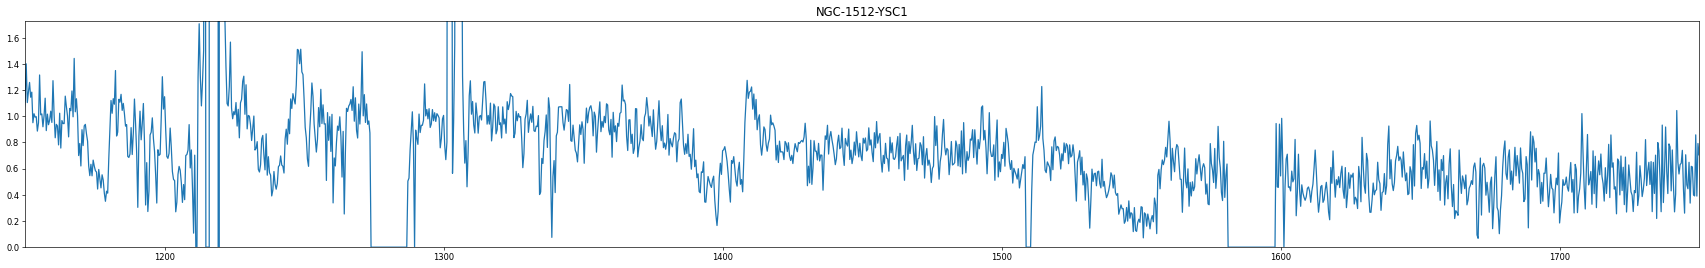

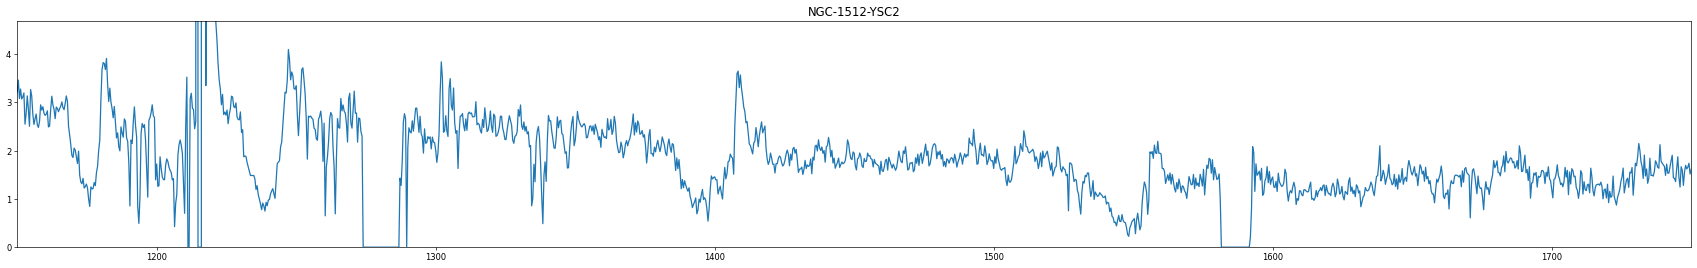

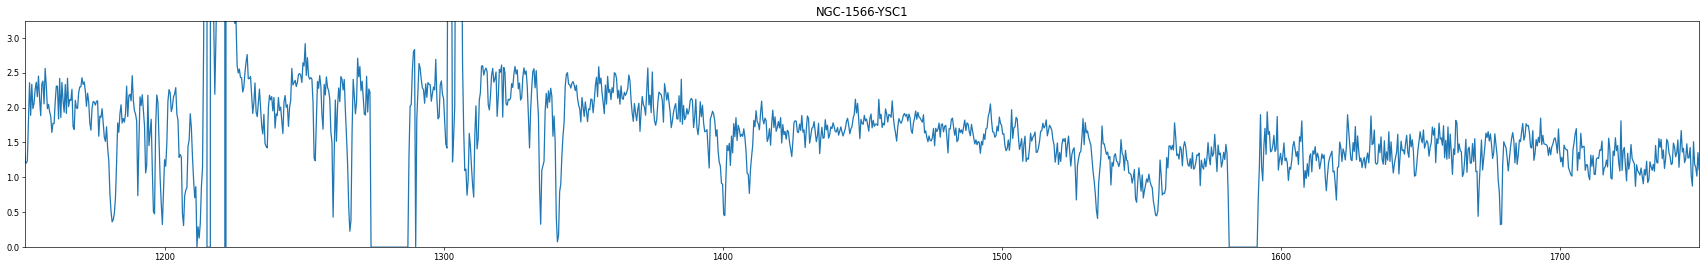

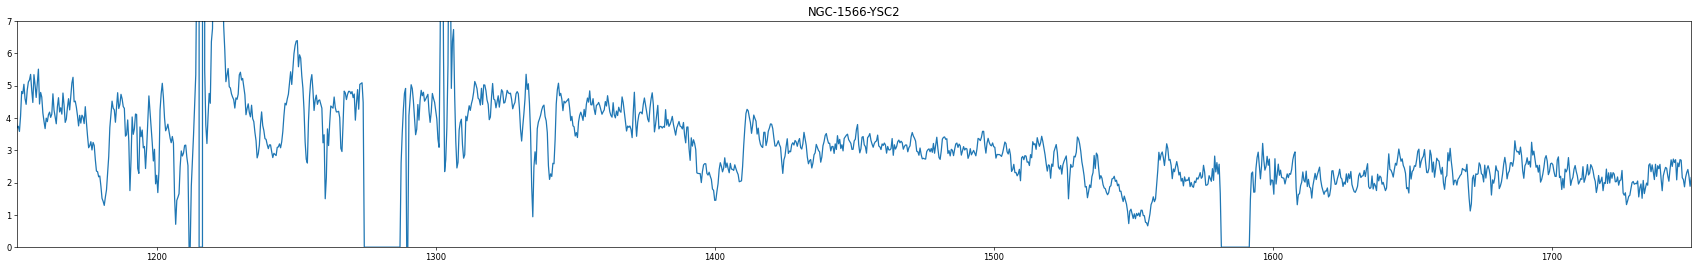

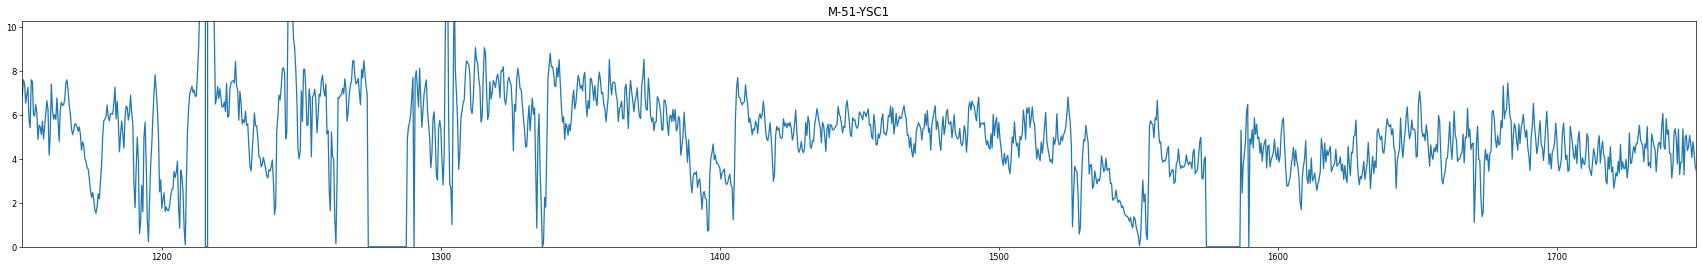

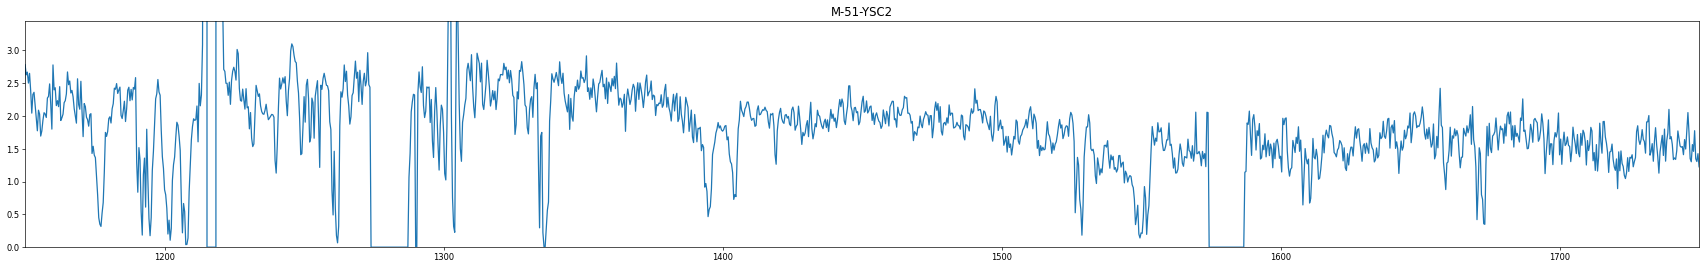

In [28]:
for igalaxy in range(3):
  galaxy = galaxies[igalaxy]
 # z=redshift(galaxy)
  for icluster in range(2):
    cluster = clusters[icluster]

# Load model
    data = np.loadtxt(path + galaxy + '-' + cluster + '_ssp_up_maskedSpectrum.txt', skiprows = 7)
    x, y, dy, mask = np.transpose(data)
    fig, axes = plt.subplots(figsize=(36,5), dpi=60)
    plt.plot(x,y)
    plt.xlim(1150,1750)
    goodpts = np.where(x < 1200)
    plt.ylim(min(y),1.2*max(y[goodpts]))
    plt.title(galaxy+ '-' + cluster,fontsize=14)
